In [1]:
from __future__ import print_function
import os, random, torchvision, torch
import torch.nn as nn
from torchvision import transforms, utils
import torch.optim as optim
from torch.autograd import Variable
from pytorchtools import EarlyStopping
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from skimage.measure import compare_ssim as ssim
from FWNet import FWNet
from utils import *
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
GLOBAL_SEED = 1
BATCH_SIZE = 1

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
GLOBAL_WORKER_ID = None
def worker_init_fn(worker_id):
    global GLOBAL_WORKER_ID
    GLOBAL_WORKER_ID = worker_id
    set_seed(GLOBAL_SEED + worker_id)

In [4]:
train_data = MyDataset(txt = './train_list_whole.txt', 
                       transform = transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE,
                                          drop_last = True, 
                                          num_workers = 2,
                                          shuffle = True,
                                          worker_init_fn = worker_init_fn)

In [5]:
val_data = MyDataset(txt = './val_list_whole.txt',
                     transform = transforms.ToTensor())
valloader = torch.utils.data.DataLoader(val_data, batch_size = BATCH_SIZE,
                                        drop_last = True,
                                        num_workers = 2,
                                        shuffle = True,
                                        worker_init_fn = worker_init_fn)

In [6]:
test_data = MyDataset(txt = './test_list_whole.txt',
                      transform = transforms.ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE,
                                         drop_last = True, 
                                         num_workers = 2,
                                         shuffle = False,
                                         worker_init_fn = worker_init_fn)

In [7]:
net = FWNet(1, 2)
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.03, 
                      momentum = 0.9, weight_decay = 0.0005)

# early_stopping = print_all_EarlyStopping(save_name = '../model_4/without-bg-{}'.format(TAG),
#                                          patience = 20, verbose = True)
if not os.path.exists('./temp_model'):
    os.mkdir('./temp_model')
early_stopping = EarlyStopping(save_name = './temp_model/best_fusion_model',
                                         patience = 10, verbose = True)

n_epochs = 30



rho = torch.full((BATCH_SIZE, 256, 256), 0.4, device = device)

def calc_loss(ct, mr, img_fusion, outputs):
    """Mask MSE"""
    bg_mask = get_bg_mask(ct, mr).type_as(outputs)
    fg_mask = (1.0 - bg_mask)
    fg_mask[fg_mask < 0.4] = 0.4
    loss = criterion(outputs[:, 0, :, :] * fg_mask, ct) + \
    criterion(outputs[:, 1, :, :] * fg_mask, mr)
    
    """General MSE
    loss = criterion(outputs[:, 0, :, :], ct) + \
    criterion(outputs[:, 1, :, :], mr)
    """
    
    """Sparsity Penalty"""
    sparsity_penalty = 3 * kl_divergence(rho, img_fusion)
    loss += sparsity_penalty

    return loss


In [8]:
# Training 
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
for epoch in range(1, n_epochs + 1):
    net.train()
    for i, data in enumerate(trainloader, 1):
        ct, mr = data
        ct, mr = ct.to(device), mr.to(device)
        optimizer.zero_grad()
        img_fusion, outputs = net(torch.cat((ct, mr), dim = 1))
        
        loss = calc_loss(ct, mr, img_fusion, outputs)
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    # evaluation
    net.eval()
    for i, data in enumerate(valloader, 1):
        ct, mr = data
        ct, mr = ct.to(device), mr.to(device)
        img_fusion, outputs = net(torch.cat((ct, mr), dim = 1))
                
        loss = calc_loss(ct, mr, img_fusion, outputs)

        valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    early_stopping(valid_loss, net)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
print('Finished Training')

[ 1/30] train_loss: 0.05539 valid_loss: 0.03134
Validation loss decreased (inf --> 0.031338).  Saving model ...
[ 2/30] train_loss: 0.02192 valid_loss: 0.01934
Validation loss decreased (0.031338 --> 0.019340).  Saving model ...
[ 3/30] train_loss: 0.01772 valid_loss: 0.01590
Validation loss decreased (0.019340 --> 0.015898).  Saving model ...
[ 4/30] train_loss: 0.01511 valid_loss: 0.01421
Validation loss decreased (0.015898 --> 0.014208).  Saving model ...
[ 5/30] train_loss: 0.01243 valid_loss: 0.01717
EarlyStopping counter: 1 out of 10
[ 6/30] train_loss: 0.01123 valid_loss: 0.01369
Validation loss decreased (0.014208 --> 0.013691).  Saving model ...
[ 7/30] train_loss: 0.01069 valid_loss: 0.01402
EarlyStopping counter: 1 out of 10
[ 8/30] train_loss: 0.01091 valid_loss: 0.01268
Validation loss decreased (0.013691 --> 0.012682).  Saving model ...
[ 9/30] train_loss: 0.01142 valid_loss: 0.01837
EarlyStopping counter: 1 out of 10
[10/30] train_loss: 0.00944 valid_loss: 0.01090
Valida

In [9]:
net.load_state_dict(torch.load('./temp_model/best_fusion_model_checkpoint.pt'))

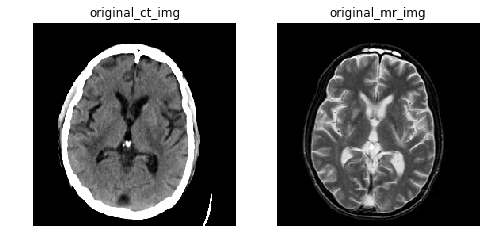

In [10]:
# See specific examples
dataiter = iter(testloader)
img_ct, img_mr = dataiter.next()
img_ct, img_mr = dataiter.next()
img_ct, img_mr = dataiter.next()
img_ct, img_mr = dataiter.next()
img_ct, img_mr = dataiter.next()
img_ct, img_mr = dataiter.next()

plt.figure(figsize = (8, 16)) 
    
plt.subplot(1, 2, 1)
plt.title('original_ct_img')
plt.imshow(np.array(img_ct[0][0] * 255, dtype = 'uint8'), plt.cm.gray)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('original_mr_img')
plt.imshow(np.array(img_mr[0][0] * 255, dtype = 'uint8'), plt.cm.gray)
plt.axis('off')

plt.show()

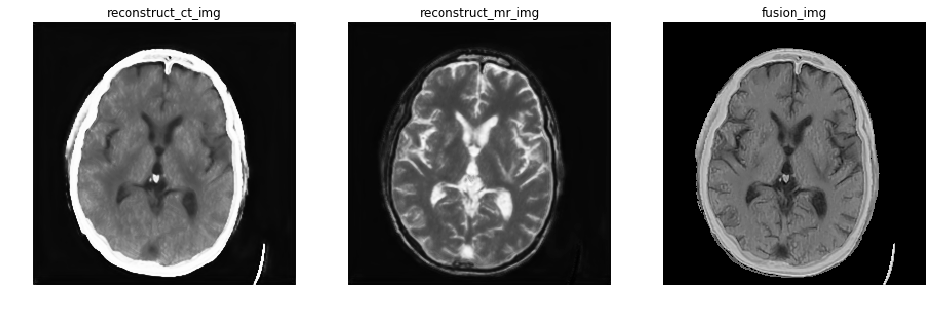

In [12]:
net.eval()
img_fusion, oo = net(torch.cat((img_ct, img_mr), dim = 1).to(device))
oo = oo.cpu()
img_fusion = img_fusion.cpu()

bg_mask = get_bg_mask(img_ct[0][0], img_mr[0][0])
fg_mask = get_fg_mask(img_ct[0][0], img_mr[0][0])

r2 = post_image(img_ct[0][0], img_mr[0][0], img_fusion[0][0], chg_bg = True, inverse = True)

with torch.no_grad():
    plt.figure(figsize = (16, 8)) 
    plt.subplot(1, 3, 1)
    plt.title('reconstruct_ct_img')
    plt.imshow(np.array(oo[0][0] * 255, dtype = 'uint8'), plt.cm.gray)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('reconstruct_mr_img')
    plt.imshow(np.array(oo[0][1] * 255, dtype = 'uint8'), plt.cm.gray)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('fusion_img')
    plt.imshow(np.array(r2 * 255, dtype = 'uint8'), plt.cm.gray)
    plt.axis('off')


In [13]:
all_data = MyDataset(txt = './final_all_data.txt', 
                     transform = transforms.ToTensor())
allloader = torch.utils.data.DataLoader(all_data, batch_size = 1, num_workers = 1)

In [14]:
# generate result
RESULT_DIR = './result'
if not os.path.exists('./result'):
    os.mkdir('./result')
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
net.eval()
with torch.no_grad():
    for i, data in enumerate(allloader, 0):
        cases = i // 24
        img_id = i % 24
        img_ct, img_mr = data
        img_ct, img_mr = img_ct.to(device), img_mr.to(device)
        
        img_fusion, reconstruct_output = net(torch.cat((img_ct, img_mr),
                                                       dim = 1).to(device))
        # scale
        r = post_image(img_ct[0][0], img_mr[0][0], img_fusion[0][0]).cpu()
        io.imsave('{}/{}_{}.tif'.format(RESULT_DIR, cases + 1, str(img_id).zfill(3)), 
                  np.array(r * 255, dtype = 'uint8'))
